In [29]:
import numpy as np
import casadi as cs
import os
from acados_template import AcadosOcp, AcadosOcpSolver, AcadosModel
import matplotlib.pyplot as plt

from quad import Quadrotor3D
from utils import skew_symmetric, quaternion_to_euler, unit_quat, v_dot_q


Define the quadrotor dynamics in Casadi

In [2]:
quad = Quadrotor3D()

p = cs.MX.sym('p',3) # Position
q = cs.MX.sym('q',4) # Quaternion

v = cs.MX.sym('v',3) # Velocity
r = cs.MX.sym('w',3) # Angle rate

x = cs.vertcat(p,q,v,r) # the complete state

# Control variables
u1 = cs.MX.sym('u1')
u2 = cs.MX.sym('u2')
u3 = cs.MX.sym('u3')
u4 = cs.MX.sym('u4')

u = cs.vertcat(u1,u2,u3,u4) # complete control

# d position 
f_p = v # position dynamics

# d quaternion
f_q = 1 / 2 * cs.mtimes(skew_symmetric(r),q) # quaternion dynamics

# d velocity
f_thrust = u*quad.max_thrust
a_thrust = cs.vertcat(0, 0, f_thrust[0] + f_thrust[1] + f_thrust[2] + f_thrust[3]) / quad.mass
g = cs.vertcat(0,0,9.81)

f_v = v_dot_q(a_thrust, q) - g # velocity dynamics

# d rate
y_f = cs.MX(quad.y_f)
x_f = cs.MX(quad.x_f)
c_f = cs.MX(quad.z_l_tau)
# rate dynamics
f_r =  cs.vertcat(
    (cs.mtimes(f_thrust.T, y_f) + (quad.J[1] - quad.J[2]) * r[1] * r[2]) / quad.J[0],
    (-cs.mtimes(f_thrust.T, x_f) + (quad.J[2] - quad.J[0]) * r[2] * r[0]) / quad.J[1],
    (cs.mtimes(f_thrust.T, c_f) + (quad.J[0] - quad.J[1]) * r[0] * r[1]) / quad.J[2])


# concatenated dynamics
x_dot = cs.vertcat(f_p, f_q, f_v, f_r)
# Casadi function for dynamics 
dynamics = cs.Function('x_dot', [x,u], [x_dot], ['x','u'], ['x_dot'])


dynamics(np.zeros((13,)), np.ones((4,)))



DM([0, 0, 0, 0, 0, 0, 0, 0, 0, 70.19, 0, 0, 0])

Test integrating the dynamics by FE

In [3]:
x_new = np.array([0,0,0, 1,0,0,0, 0,0,-3, 0,0,0])
u_new = np.array([1,1,1,1])

N = 10
dt = 0.01
for i in range(N):
    x_new = x_new + dt*dynamics(x_new, u_new)
    print(x_new)

[0, 0, -0.03, 1, 0, 0, 0, 0, 0, -2.2981, 0, 0, 0]
[0, 0, -0.052981, 1, 0, 0, 0, 0, 0, -1.5962, 0, 0, 0]
[0, 0, -0.068943, 1, 0, 0, 0, 0, 0, -0.8943, 0, 0, 0]
[0, 0, -0.077886, 1, 0, 0, 0, 0, 0, -0.1924, 0, 0, 0]
[0, 0, -0.07981, 1, 0, 0, 0, 0, 0, 0.5095, 0, 0, 0]
[0, 0, -0.074715, 1, 0, 0, 0, 0, 0, 1.2114, 0, 0, 0]
[0, 0, -0.062601, 1, 0, 0, 0, 0, 0, 1.9133, 0, 0, 0]
[0, 0, -0.043468, 1, 0, 0, 0, 0, 0, 2.6152, 0, 0, 0]
[0, 0, -0.017316, 1, 0, 0, 0, 0, 0, 3.3171, 0, 0, 0]
[0, 0, 0.015855, 1, 0, 0, 0, 0, 0, 4.019, 0, 0, 0]


Now to define the Optimal Control Problem

Cost function:
$l(x,u) = \vert \vert V_x x + V_u u - y_{ref} \vert \vert^2_W$

In [4]:
x_dot = cs.MX.sym('x_dot', dynamics(x=x, u=u)['x_dot'].shape) # x_dot has the same dimensions as the dynamics function output
#print(dynamics(x=x, u=u)['x_dot'])

t_horizon = 1
terminal_cost = 1

acados_model = AcadosModel()


acados_model.name = 'quad_OCP'
acados_model.x = x
acados_model.u = u
#acados_model.x_dot = x_dot


acados_model.f_expl_expr = dynamics(x=x, u=u)['x_dot'] # x_dot = f
acados_model.f_impl_expr = x_dot - dynamics(x=x, u=u)['x_dot'] # 0 = f - x_dot

#print(acados_model)

acados_source_path = os.environ['ACADOS_SOURCE_DIR']

acados_ocp = AcadosOcp()

acados_ocp.acados_include_path = acados_source_path + '/include'
acados_ocp.acados_lib_path = acados_source_path + '/lib'

acados_ocp.model = acados_model
acados_ocp.dims.N = N # prediction horizon
acados_ocp.solver_options.tf = t_horizon # look ahead time

acados_ocp.cost.cost_type = 'LINEAR_LS' # weigths times states (as opposed to a nonlinear relationship)
acados_ocp.cost.cost_type_e = 'LINEAR_LS' # end state cost


nx = acados_model.x.size()[0]
nu = acados_model.u.size()[0]
ny = nx + nu # y is x and u concatenated for compactness of the loss function

## Optimization costs
acados_ocp.cost.Vx = np.zeros((ny,nx)) # raise the dim of x to the dim of y
acados_ocp.cost.Vx[:nx, :nx] = np.eye(nx) # weight only x
acados_ocp.cost.Vx_e = np.eye(nx) # end x cost

acados_ocp.cost.Vu = np.zeros((ny,nu)) # raise the dim of u to the dim of y
acados_ocp.cost.Vu[-nu:, -nu:] = np.eye(nu) # weight only u

# x cost (dim 12)
q_cost = np.array([10, 10, 10, 0.1, 0.1, 0.1, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]) # euler angles
# add one more weigth to account for the 4 quaternions instead of 3 EA
q_diagonal = np.concatenate((q_cost[:3], np.mean(q_cost[3:6])[np.newaxis], q_cost[3:]))
r_cost = np.array([0.1, 0.1, 0.1, 0.1]) # u cost (dim 4)
acados_ocp.cost.W = np.diag(np.concatenate((q_diagonal, r_cost))) # error costs
acados_ocp.cost.W_e = np.diag(q_diagonal) * terminal_cost # end error cost


# reference trajectory (will be overwritten later, this is just for dimensions)
x_ref = np.zeros(nx)
acados_ocp.cost.yref = np.concatenate((x_ref, np.array([0.0, 0.0, 0.0, 0.0])))
#print(acados_ocp.cost.yref.shape)
acados_ocp.cost.yref_e = x_ref

acados_ocp.constraints.x0 = x_ref

acados_ocp.constraints.lbu = np.array([0] * 4)
acados_ocp.constraints.ubu = np.array([1] * 4)
acados_ocp.constraints.idxbu = np.array([0,1,2,3]) # Indices of bounds on u 

## Solver options
acados_ocp.solver_options.qp_solver = 'FULL_CONDENSING_HPIPM'
acados_ocp.solver_options.hessian_approx = 'GAUSS_NEWTON'
acados_ocp.solver_options.integrator_type = 'ERK'
acados_ocp.solver_options.print_level = 0
acados_ocp.solver_options.nlp_solver_type = 'SQP_RTI'

# Compile acados OCP solver if necessary
json_file = '_acados_ocp.json'

#print(acados_ocp.items())

#print(acados_model['x_dot'])
acados_ocp_solver = AcadosOcpSolver(acados_ocp)#, json_file=json_file)







rm -f libacados_ocp_solver_quad_OCP.so
rm -f acados_solver_quad_OCP.o
cc -fPIC -std=c99   -O2 -I/home/ja/Projects/MPC_drone/acados/include -I/home/ja/Projects/MPC_drone/acados/include/acados -I/home/ja/Projects/MPC_drone/acados/include/blasfeo/include -I/home/ja/Projects/MPC_drone/acados/include/hpipm/include  -c -o acados_solver_quad_OCP.o acados_solver_quad_OCP.c
cc -fPIC -std=c99   -O2 -I/home/ja/Projects/MPC_drone/acados/include -I/home/ja/Projects/MPC_drone/acados/include/acados -I/home/ja/Projects/MPC_drone/acados/include/blasfeo/include -I/home/ja/Projects/MPC_drone/acados/include/hpipm/include  -c -o quad_OCP_model/quad_OCP_expl_ode_fun.o quad_OCP_model/quad_OCP_expl_ode_fun.c
cc -fPIC -std=c99   -O2 -I/home/ja/Projects/MPC_drone/acados/include -I/home/ja/Projects/MPC_drone/acados/include/acados -I/home/ja/Projects/MPC_drone/acados/include/blasfeo/include -I/home/ja/Projects/MPC_drone/acados/include/hpipm/include  -c -o quad_OCP_model/quad_OCP_expl_vde_forw.o quad_OCP_model/qua

Add a reference trajectory

In [93]:
u_target = np.array([0,0,0,0])
x_target = np.array([0,0,1, 1,0,0,0, 0,0,0, 0,0,0], dtype=float)
yref = np.empty((N,ny))
for j in range(0,N):
    yref[j,:] = np.concatenate(( x_target*j/2, u_target))
    #print(ref)
    acados_ocp_solver.set(j, "yref", yref[j,:])
    
yref_N = x_target*N/2
acados_ocp_solver.set(N, "yref", yref_N)

#acados_ocp_solver.get(1,'yref')
    #yref[j,:] = ref
#print(yref)
#acados_ocp.cost.yref = yref

In [91]:

def run_optimization(x_init=None):
    
    
    if x_init is None:
        x_init = np.array([0,0,0, 1,0,0,0, 0,0,0, 0,0,0]) 
    # Get u
    
    
    acados_ocp_solver.set(0, 'lbx', x_init)
    acados_ocp_solver.set(0, 'ubx', x_init)
    acados_ocp_solver.set(0, 'x', x_init)
    
    # Solve OCP
    acados_ocp_solver.solve()
    
    # preallocate memory
    w_opt_acados = np.ndarray((N, 4)) 
    x_opt_acados = np.ndarray((N + 1, len(x_init)))
    x_opt_acados[0, :] = acados_ocp_solver.get(0, "x") # should be x_init?
    for i in range(N):
        w_opt_acados[i, :] = acados_ocp_solver.get(i, "u") # optimal control
        x_opt_acados[i + 1, :] = acados_ocp_solver.get(i + 1, "x") # state under optimal control

    #w_opt_acados = np.reshape(w_opt_acados, (-1))
    return x_opt_acados, w_opt_acados
#print(w_opt_acados)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.0


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 0 dimension(s)

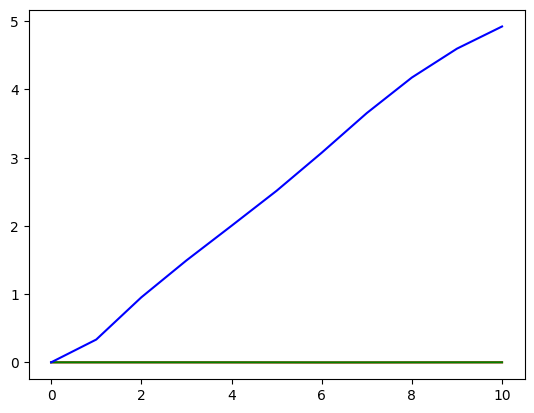

In [99]:
x0 = np.array([0,0,0, 1,0,0,0, 0,0,0, 0,0,0]) 
x_opt_acados, w_opt_acados = run_optimization(x0)

print(yref[:,0])
print(yref_N[0])
fig = plt.figure()
plt.plot(x_opt_acados[:,0],'r')
plt.plot(x_opt_acados[:,1],'g')
plt.plot(x_opt_acados[:,2], 'b')

plt.plot(np.concatenate((yref[:,0], yref_N[0])),'r--')
plt.plot(yref[:,1],'g--')
plt.plot(yref[:,2], 'b--')

#print(x_opt_acados)
#print(w_opt_acados)
#acados_ocp.cost.yref